# EE267 Spring 2025 Term Project: Swimmer Segmentation and Pose Estimation

## Objective
Articial Intelligence (AI) has transformed computer vision, enabling machines to interpret visual data
much like humans. Two critical techniques in this field are image segmentation and human pose
estimation. Image segmentation isolates objects from their backgrounds, essential for tasks like sports
analysis and medical imaging. Human pose estimation, on the other hand, detects body joints and
movement, providing valuable insights for elds such as biomechanics and augmented reality.

In this assignment, we will do the following:
1. Segment the swimmer from the background using Meta's Segment Anything Model (SAM).
2. Detect and label the swimmer's joints using a human pose estimation model of your choice
(either YOLO or Meta Sapiens).

## Experiment

### Task 0: Data Pre-processing

Complete Guide to Image Preprocessing Techniques in Python: https://medium.com/@maahip1304/the-complete-guide-to-image-preprocessing-techniques-in-python-dca30804550c

In [56]:
# Import libraries
import os
import numpy as np
import cv2

# Data types
from typing import List, Tuple
from numpy import ndarray

In [57]:
# Image dataset paths
SWIM_VIDEO_FOLDER = 'data/Swim Dataset/'
INPUT_IMAGES_FOLDER = 'data/input/'
OUTPUT_FOLDER = 'data/output/'

# Image variables
IMAGE_SIZE = 256

#### Video Pre-processing

In [25]:
# Split Video into frames
back_video = cv2.VideoCapture(SWIM_VIDEO_FOLDER + 'back-training.mp4')
breast_video = cv2.VideoCapture(SWIM_VIDEO_FOLDER + 'breast-training.mp4')
fly_video = cv2.VideoCapture(SWIM_VIDEO_FOLDER + 'fly-training.mp4')
free_video = cv2.VideoCapture(SWIM_VIDEO_FOLDER + 'freestyle-training.mp4')

#### Image Pre-processing

In [ ]:
def preprocess(video: List[ndarray], stroke_name: str, target_size: Tuple[int, int] = (IMAGE_SIZE, IMAGE_SIZE)) -> List[ndarray]:
    """
    Image pre-processing for image segmentation & pose estimation:
    1. Resizing
    2. Image denoising
    3. Image enhancement
    4. Normalization & Batching
    5. Save images for image segmentation + pose estimation

    Parameters:
        images (List[ndarray]): images to pre-process

    Returns:
        List[ndarray]: post-processed images
    """
    # os.makedirs(INPUT_IMAGES_FOLDER, exist_ok=True)

    images = []
    frame_count = 0
    while True:
        ret, frame = video.read()
        # If no frame is returned, the video has ended.
        if not ret:
            break
        
        # MAIN IMAGE PRE-PROCESSING CODE BLOCK
        # 1. Image resizing
        resized_frame = cv2.resize(frame, target_size, interpolation=cv2.INTER_AREA)

        # Advanced Image Processing
        # Image denoising: smoothing, blurring, filtering, sharpening
        """ We won't want to smooth or blur for our use case. 
            In lecture professor said, the blue water and bubbles makes it hard to segment swimmers from rest of image. 
            If anything, we want to sharpen image & detect edges."""

        ## Edge-preserving smoothing filter: bilateral filter?

        ## Image sharpening: Laplacian filter, Unsharp masking

        ## Edge detection: Canny operator

        # Image enhancement
        ## Contrast enhancement: histogram equalization

        # Normalization (pixel intensity)

        # Batching

        
        # 5. Save the resized frame to the input directory for image segmentation + pose estimation
        # frame_filename = os.path.join(INPUT_IMAGES_FOLDER, f"{stroke_name}_{frame_count:05d}.png")
        # cv2.imwrite(frame_filename, resized_frame)
        images.append(resized_frame)
        
        print(f"Processed frame {frame_count}")
        frame_count += 1
    
    # Release the video capture object and close all windows.
    video.release()
    cv2.destroyAllWindows()
    print(f"Extraction complete. Total frames processed: {frame_count}")
    
    return images

In [ ]:
back_images = preprocess(back_video, 'back', target_size=(1024, 1024))

Processed frame 0
Processed frame 1
Processed frame 2
Processed frame 3
Processed frame 4
Processed frame 5
Processed frame 6
Processed frame 7
Processed frame 8
Processed frame 9
Processed frame 10
Processed frame 11
Processed frame 12
Processed frame 13
Processed frame 14
Processed frame 15
Processed frame 16
Processed frame 17
Processed frame 18
Processed frame 19
Processed frame 20
Processed frame 21
Processed frame 22
Processed frame 23
Processed frame 24
Processed frame 25
Processed frame 26
Processed frame 27
Processed frame 28
Processed frame 29
Processed frame 30
Processed frame 31
Processed frame 32
Processed frame 33
Processed frame 34
Processed frame 35
Processed frame 36
Processed frame 37
Processed frame 38
Processed frame 39
Processed frame 40
Processed frame 41
Processed frame 42
Processed frame 43
Processed frame 44
Processed frame 45
Processed frame 46
Processed frame 47
Processed frame 48
Processed frame 49
Processed frame 50
Processed frame 51
Processed frame 52
Pro

KeyboardInterrupt: 

In [ ]:
breast_images = preprocess(breast_video, 'breast', target_size=(1024, 1024))

In [ ]:
fly_images = preprocess(fly_video, 'back', target_size=(1024, 1024))

In [ ]:
free_images = preprocess(free_video, 'breast', target_size=(1024, 1024))

#### Image Augmentation (if needed)

### Task 1: Swimmer Segmentation with SAM
Description:

Use Meta’s SAM model to isolate the swimmer from each frame provided.

Instructions:
1. Load the provided dataset of swimmer images.
2. Apply SAM to each image to segment the swimmer, separating them from the background.
3. Save the segmented images for the next task.

Meta SAM Github: https://github.com/facebookresearch/segment-anything

In [83]:
# Import libraries
import matplotlib.pyplot as plt
import torch
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

# Data Types
from matplotlib.axes import Axes

# Check if GPU is available for PyTorch
device = "cuda" if torch.cuda.is_available() else "cpu"

In [84]:
def show_mask(mask: ndarray, ax: Axes, random_color: bool = False) -> None:
    """ 
    Display Segmentation Mask produced by Meta SAM model for an image.
    
    Parameters:
        mask (ndarray): Segmentation Mask to display
        ax (Axes): Axes/plot to plot mask on
        random_color (bool): flag for generating random colored masks
    """
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 255/255, 0/255, 0.6])             # Changed default mask to green because of blue water background
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)    # Reshape mask
    ax.imshow(mask_image)                                           # Plot mask
    
def show_points(coords: ndarray, labels: ndarray, ax: Axes, marker_size: int = 375) -> None:
    """ 
    Display segmentation points inputted to Meta SAM model for an image.

    Parameters:
        coords (ndarray): coordinates of segmentation points to display
        labels (ndarray): labels, generated by Meta SAM, for segmentation points (1 - foreground point, 0 - background point)
        ax (Axes): Axes/plot to plot points on
        marker_size (int): point marker size
    """
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

In [89]:
# Meta Segment Anything Model (SAM) variables
MODEL_PATH = 'models/sam_vit_b_01ec64.pth'
SAM_TYPE = 'vit_b'

# Load Meta SAM variant
sam = sam_model_registry[SAM_TYPE](checkpoint=MODEL_PATH)
sam.to(device=device)
print("SAM Model loaded")

SAM Model loaded


In [91]:
# Load images to segment
image = cv2.imread('data/input/back_00000.png') # TODO: Loop through and segment all images - Segmenting 1 image for testing purposes
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [95]:
# Initialize points to segment image
# TODO: we need to find a way to set this at the swimmer
input_point = np.array([[500, 375]])
input_label = np.array([1])

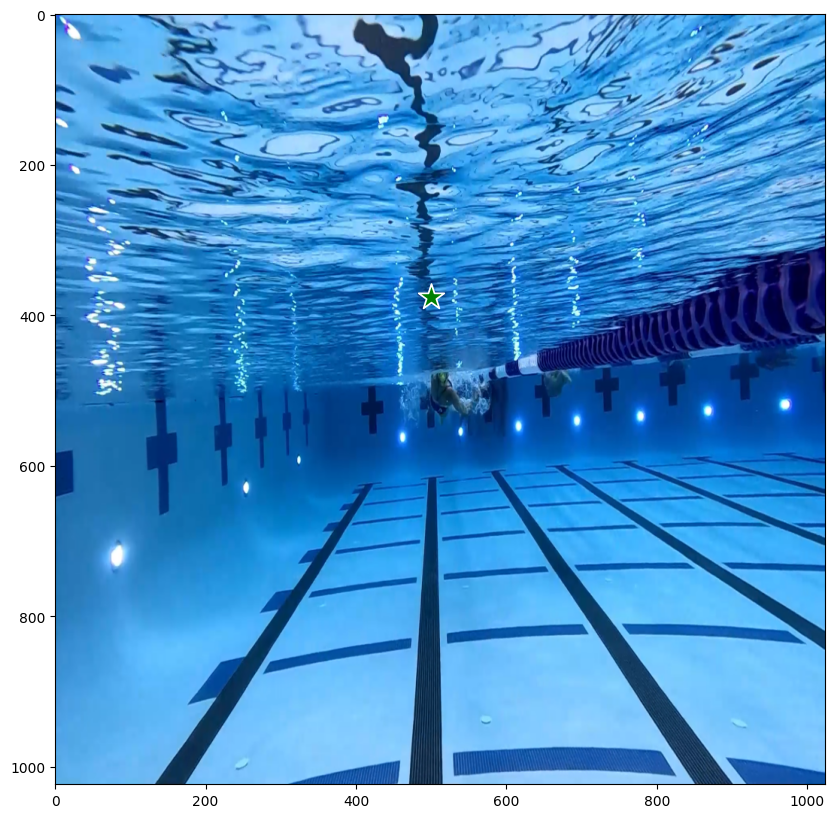

In [96]:
# Display image with segmentation point
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  

In [97]:
# Image Segmentation w/ Meta SAM
predictor = SamPredictor(sam)
predictor.set_image(image)

In [98]:
# Segment image based on input segmentation points & labels
# Get masks, scores, and log probabilities of predicted masks
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)
masks.shape  # (number_of_masks) x H x W

(3, 1024, 1024)

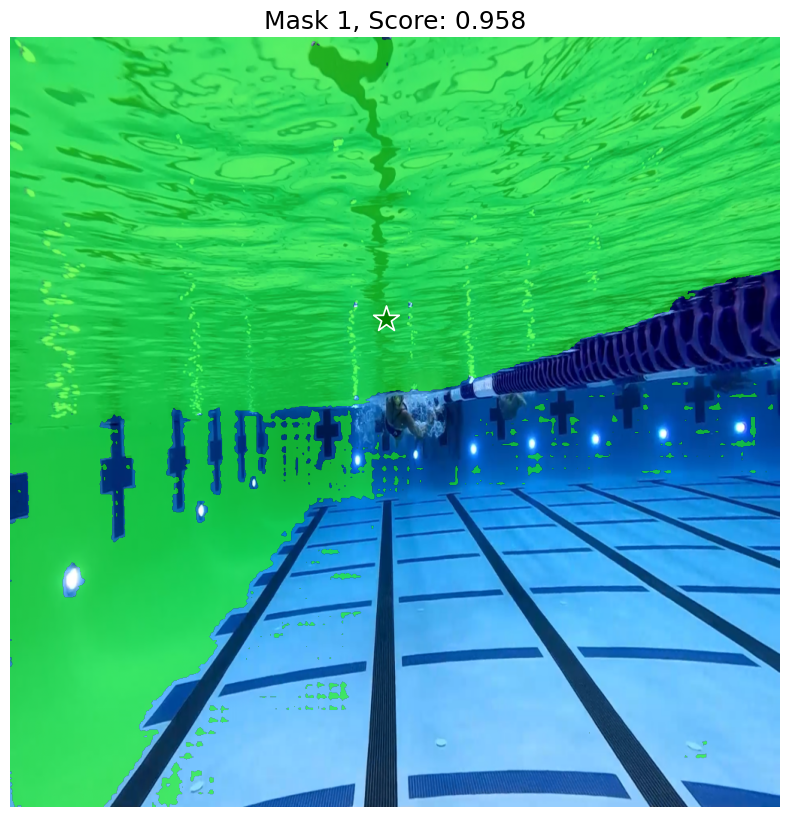

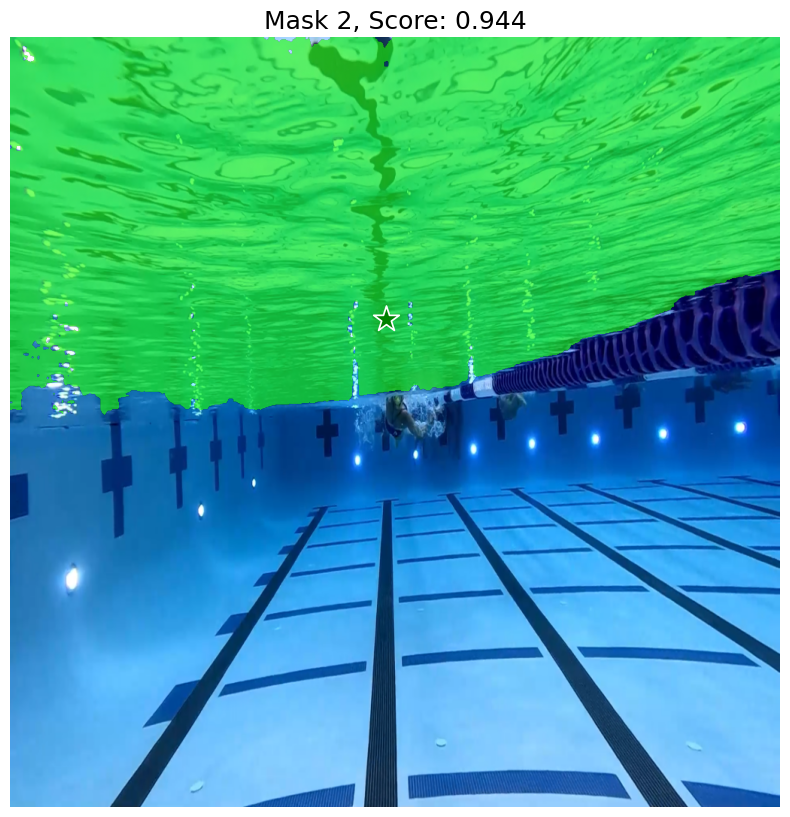

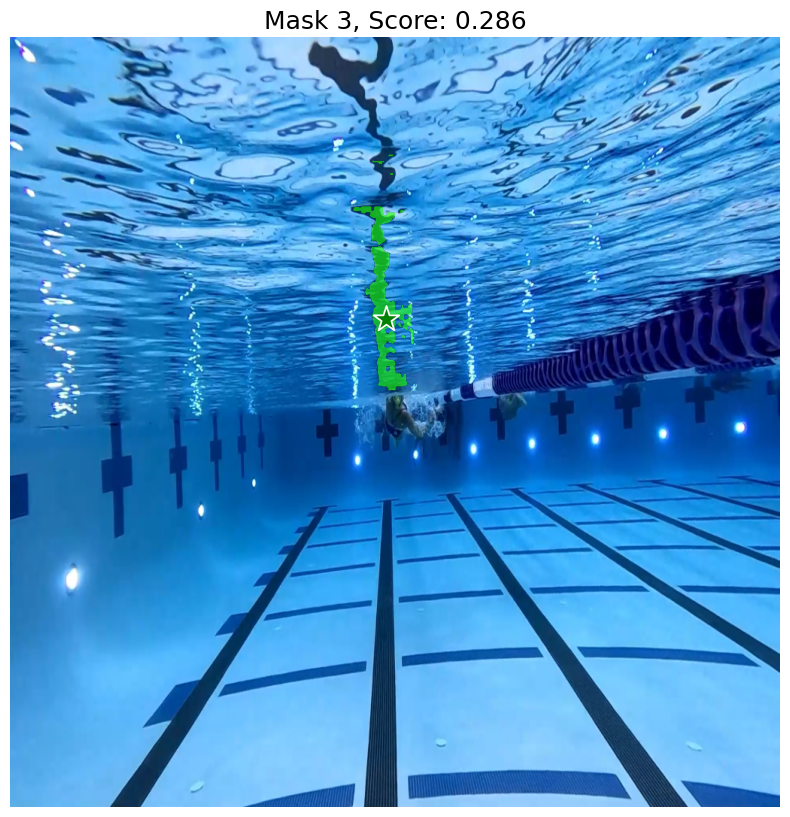

In [99]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    # Visualize image + masks + segmentation points + scores
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()

In [100]:
# Image segmentation w/ multiple segmentation points
input_point = np.array([[500, 375], [1125, 625]])
input_label = np.array([1, 1])

mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask

In [ ]:
# Segment image using top scoring mask
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)
masks.shape

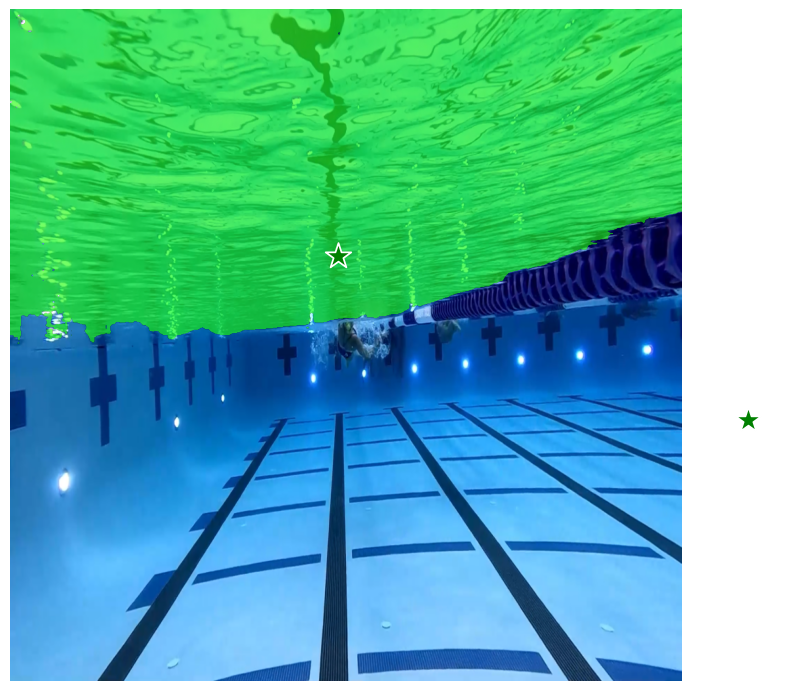

In [104]:
# Visualize segmented image using w/ top scoring mask
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show() 

### Task 2: Pose Estimation on the Segmented Swimmer

Description:

With the segmented swimmer images, utilize a human pose estimation model to
detect the swimmer’s joints.

Model Options:
1. YOLO (congured for pose estimation).
2. Meta Sapiens

Instructions:
1. Choose either YOLO or Meta Sapiens for pose estimation.
2. Run the selected model on the segmented images to identify key joint positions.
3. Save images with overlaid joint positions and export joint coordinates for each frame.


Ultralytics YOLOv11 Pose Estimation Docs: https://docs.ultralytics.com/tasks/pose/

In [12]:
# Import libraries
from ultralytics import YOLO

In [13]:
# Initialize Pose Estimation Model
model = YOLO('models/yolo11n-pose.pt')

In [21]:
# Identify key joint positions


In [ ]:
# Overlay images with joint positions

In [ ]:
# Save overlaid images